<a href="https://colab.research.google.com/github/Bouncy0Knight/Exercise7/blob/main/CompModNervSys_exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System 
# Exercise 7: Simulating the Hodgkin-Huxley model in NEURON - Part II

### Exercise goals

1) Understand the time course of conductances and gating variables during the action potential in the HH model

2) Understand origin of absolute and relative refractory periods

3) Analyze firing behavior of neurons with the HH model with step currents


Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with <span style="color:red">***Q:*** </span> preceding them, write your responses in text cells. 


We'll first install neuron like last time

In [109]:
%pip install neuron # only need to run this cell once to install 
                    # neuron in the local jupyter environment

%pip install Ipython --upgrade # update IPython to allow reloading modules below

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the packages we'll be using

In [110]:
from neuron import h # all NEURON hoc functions are accessed through h
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary 
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Ionic mechanisms of the HH action potential

We'll start out with the same model we created in exercise 6 of a space clamped axon with the Hodgkin-Huxley sodium, potassium, and leak conductances:

For our geometry, we'll again use a diameter of $500 \; \mu m$ and length of $100 \; \mu m$. Since the axon is space clamped, we can set `nseg` (the number of segments) to 1. Then, we just insert our biophysical mechanisms, which is the built in `hh` model in this case. Inserting the `hh` model adds all three conductances from the HH model: `gNa` for sodium conductance, `gK` for potassium conductance, and `gl` for the passive leak conductance (all in $S/cm^{2}$). Finally, we set up recording and simulation instrumentation. We'll use a current clamp so we can inject current and allow the voltage to evolve and generate action potentials (APs). And this time, we'll record all the underlying state variables of the model to better understand the underlying mechanism of the AP. 

Fill in the missing code below based on the instructions above.

In [111]:
axon = h.Section(name='axon')
# Model geometry
axon.diam =  500 # diameter in microns
axon.L =  100# length in microns
axon.nseg =  1# sets number of segments
# Model biophysics
axon.insert('hh') 
# Model instrumentstion
# Stimulation
iclamp = h.IClamp(axon(0.5)) # add
# Recordings
t_vec = h.Vector() # time vector
t_vec.record(h._ref_t)
V_vec = h.Vector() # intracellular voltage (same as membrane potential in our case)
V_vec.record(axon(0.5)._ref_v)
# ** Currents **
Iclamp_vec = h.Vector() # current clamp current (nA)
Iclamp_vec.record(iclamp._ref_i)
Ina_vec = h.Vector() # sodium current (mA/cm2)
Ina_vec.record(axon(0.5)._ref_ina)
Ik_vec = h.Vector() # potassium current (mA/cm2)
Ik_vec.record(axon(0.5)._ref_ik)
# ** Conductances **
gna_vec = h.Vector() # sodium conductance (S/cm2)
gna_vec.record(axon(0.5)._ref_gna_hh) # note the 'hh' suffix, required by neuron to specify which mechanism this conductance belongs to
gk_vec = h.Vector() # potassium conductance (S/cm2)
gk_vec.record(axon(0.5)._ref_gk_hh)
# ** Gating variables **
n_vec = h.Vector() # potassium activation gate (0-1)
n_vec.record(axon(0.5)._ref_n_hh)
m_vec = h.Vector() # sodium activation gate
m_vec.record(axon(0.5)._ref_m_hh) 
h_vec = h.Vector() # sodium inactivation gate
h_vec.record(axon(0.5)._ref_h_hh)

Vector[153]

Now to run our simulation, we need to choose our initial condition and simulation settings. 
We'll first simulate an action potential due to a brief current pulse. Use an initial voltage (`h.v_init`) of $-65 \; mV$, time step of $0.0125 \; ms$, temperature (`h.celsius`) of $6.3^{\circ} C$, and duration (`h.tstop`) of $8 \; ms$. 

Since we didn't set it above, we also need to specify our current stimulus. Use a $2 \; ms$ current pulse that starts at $1 \; ms$ and has an amplitude of $20 \; nA$. 

Start by plotting the membrane potential $V_{m}$ vs. time using whatever plotting package you prefer (`matplotlib` may be easiest, you can copy the format used in previous exercises).

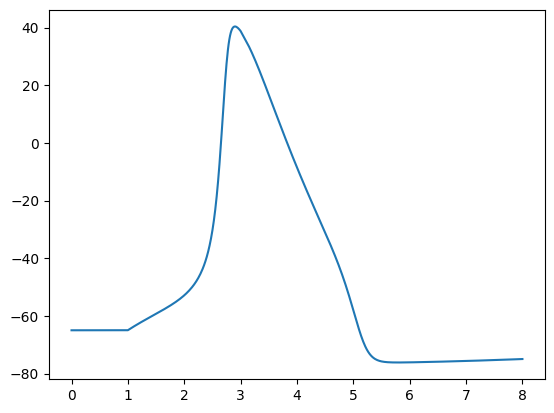

In [112]:
# Current clamp settings
iclamp.delay =1 # ms
iclamp.dur = 2 # ms
iclamp.amp = 20# nA

# Simulation settings
h.v_init =  -65# mV - initial voltage of the model system 
h.dt =  0.0125 # ms - time step
h.celsius = 6.3# degrees celsius - temperature of simulation, set to room temperature
h.tstop =  8# ms - simulation duration

# Run
h.run()

# Your plotting code goes here
#fig = plt.figure()
plt.plot(t_vec,V_vec)


You should see an action potential. 

<span style="color:red">***Q1***: Approximately what voltage does the AP reach at its upper and lower extremes? What parameters do you think control these values?</span>

Reversal Potentials control these values. The AP reaches a peak of 40mV and a lower extreme of -75 mV. 

Let's first look at how the ionic currents vary during the action potential. We'll focus on the main culprits, the sodium and potassium currents for now and ignore the leak current since it wouldn't change the story much anyway. Run the code block below to instantiate a function to plot the voltage with the sodium and potassium currents overlaid on a second set of axes. 

In [113]:
def plotV_and_Is(t_vec,V_vec,Ina_vec,Ik_vec,title=None):
    # t_vec - time vector (can be NEURON Vector or numpy array) (ms)
    # V_vec - membrane potential vector (can be NEURON Vector or numpy array) (mV)    
    # Ina_vec - sodium current density vector (can be NEURON Vector or numpy array) (mA/cm2)
    # Ik_vec - potassium current density vector (can be NEURON Vector or numpy array) (mA/cm2)
    if isinstance(Ina_vec,type(h)):
        Ina_vec = Ina_vec.to_python(np.zeros(len(Ina_vec)))
    if isinstance(Ik_vec,type(h)):
        Ik_vec = Ik_vec.to_python(np.zeros(len(Ik_vec)))
    
    Iion_vec = Ina_vec + Ik_vec # ionic current (excluding leak)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=t_vec,y=V_vec,name='Vm',line=dict(color='rgb(0,0,0)')),secondary_y = False)
    fig.update_layout(yaxis = dict(range=[-80,50]))
    fig.add_trace(go.Scatter(x=t_vec,y=Iion_vec,name='Ina+Ik'),secondary_y = True)
    fig.add_trace(go.Scatter(x=t_vec,y=Ina_vec,name='Ina'),secondary_y = True)
    fig.add_trace(go.Scatter(x=t_vec,y=Ik_vec,name='Ik'),secondary_y = True)
    fig['layout']['xaxis']['title']='time (ms)'
    fig.update_yaxes(title_text="Vm (mV)", secondary_y=False)
    fig.update_yaxes(title_text="Current density (mA/cm2)", secondary_y=True)    
    if title is not None:
        fig.update_layout(title=title)    
    fig.show()    

Using `plotV_and_Is`, plot the action potential with the ionic currents overlaid. You may want to copy and paste your current clamp and simulation settings below in case you'd like to change settings and replot in a single code cell. 

In [114]:
# Current clamp settings
iclamp.delay =1 # ms
iclamp.dur = 60 # ms
iclamp.amp = 30# nA

# Simulation settings
h.v_init =  -65# mV - initial voltage of the model system 
h.dt =  2 # ms - time step
h.celsius = 6.3# degrees celsius - temperature of simulation, set to room temperature
h.tstop =  100# ms - simulation duration

# Run
h.run()

# Call plotV_and_Is here
plotV_and_Is(t_vec,V_vec,Ina_vec,Ik_vec);

Changed dt


<span style="color:red">***Q2:***  Describe how the sodium and potassium currents evolve during the action potential. In your answer, you should discuss how the direction of each current is linked to its effect on the voltage (depolarizing or repolarizing). Why does the current go up then down?
</span>

The sodium and potassium currents start at a rest level, and slowly rise over a period of 2-3 ms, before falling back down to the rest level. The positive current generated by K is repolarizing, and the negative current generated by Na is depolarizing. The current goes up in response to the current pulse, and then slowly fades to our current clamp once the pulse has passed. 

With the leaky-integrate and fire neuron model, we defined a fixed membrane potential (the *voltage threshold*) at which an AP fired. Let's see how well this approximates the behavior of the HH model. In the same coding block above, vary the amplitude and duration of the current stimulus and plot the membrane potential with the currents overlaid to help you answer the following questions:

<span style="color:red">***Q3:***  Is the voltage at which the AP initiates fixed for all durations? What needs to happen to the net current for an AP to initiate? 
</span>

The net current needs to go below 0 for the AP to initiate. The voltage isn't fixed for all durations.

Now, let's look at how the conductances vary during the action potential. Run the code block below to instantiate a function that will generate an interactive plot overlaying the voltage, total conductance, sodium conductance, and potassium conductance. As input, it takes the time vector `t_vec`, membrane potential vector `V_vec`, sodium conductance vector `gna_vec`, potassium conductance vector `gk_vec`, and the value of the leak conductance `gl_val`, which can be obtained with `axon(0.5).gl_hh`. 

In [115]:
def plotV_and_gs(t_vec,V_vec,gna_vec,gk_vec,gl_val,title=None):
    # t_vec - time vector (can be NEURON Vector or numpy array) (ms)
    # V_vec - membrane potential vector (can be NEURON Vector or numpy array) (mV)
    # gna_vec - sodium conductance vector (expects NEURON Vector) (S/cm2)
    # gk_vec - potassium conductance vector (expects NEURON Vector) (S/cm2)
    # gl_val - value of leak conductance (S/cm2)
    gna_vec = gna_vec.to_python(np.zeros(len(gna_vec)))    
    gk_vec = gk_vec.to_python(np.zeros(len(gk_vec)))
    g_vec = (gna_vec + gk_vec + gl_val)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=t_vec,y=V_vec,name='Vm',line=dict(color='rgb(0,0,0)')),secondary_y = False)
    fig.update_layout(yaxis = dict(range=[-80,50]))
    fig.add_trace(go.Scatter(x=t_vec,y=g_vec,name='g/gmax'),secondary_y = True)
    fig.add_trace(go.Scatter(x=t_vec,y=gna_vec,name='gNa/gNa_max'),secondary_y = True)
    fig.add_trace(go.Scatter(x=t_vec,y=gk_vec,name='gK/gK_max'),secondary_y = True)
    fig['layout']['xaxis']['title']='time (ms)'
    fig.update_yaxes(title_text="Vm (mV)", secondary_y=False)
    fig.update_yaxes(title_text="g (normalized to max)", secondary_y=True)
    fig.show()
    if title is not None:
        fig.update_layout(title=title)        

<span style="color:red">***Q4:*** After inspecting the function, what was the leak conductance used for? And, why did we not record a vector of leak conductance over time? </span> 

Below, use `plotV_and_gs` to plot the action potential with the conductances now overlaid. Use the same simulation parameters as above.

In [116]:
# Current clamp settings

# Simulation settings

gl_val = axon(0.5).gl_hh
# Run
h.run()

# Add function arguments to plotV_and_gs
plotV_and_gs(t_vec,V_vec,gna_vec,gk_vec,gl_val);

Hopefully you see something like what we showed in class! The sodium conductance rises rapidly and starts to shut off (inactivate) near the peak of the action potential. Meanwhile the potassium conductance rises more slowly and doesn't start to decay until the membrane potential is almost back to its resting value. 

Finally, let's see how the gating variables evolve during the action potential. Run the code cell below to instantiuate the `plotV_and_gates` function, which plots the potassium activation gate $n$, sodium activation gate $m$, and sodium inactivation gate $h$ overlaid with the action potential.

In [117]:
def plotV_and_gates(t_vec,V_vec,n_vec,m_vec,h_vec,title=None):
    # t_vec - time vector (can be NEURON Vector or numpy array) (ms)
    # V_vec - membrane potential vector (can be NEURON Vector or numpy array) (mV)
    # n_vec - potassium activation gating variable (can be NEURON Vector or numpy array)
    # m_vec - sodium activation gating variable (can be NEURON Vector or numpy array)
    # h_vec - sodium inactivation gating variable (can be NEURON Vector or numpy array)

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=t_vec,y=V_vec,name='Vm',line=dict(color='rgb(0,0,0)')),secondary_y = False)
    fig.update_layout(yaxis = dict(range=[-80,50]))
    fig.add_trace(go.Scatter(x=t_vec,y=n_vec,name='n'),secondary_y = True)
    fig.add_trace(go.Scatter(x=t_vec,y=m_vec,name='m'),secondary_y = True)
    fig.add_trace(go.Scatter(x=t_vec,y=h_vec,name='h'),secondary_y = True)
    fig['layout']['xaxis']['title']='time (ms)'
    fig.update_yaxes(title_text="Vm (mV)", secondary_y=False)
    fig.update_yaxes(title_text="State", secondary_y=True)
    fig.update_layout(yaxis2 = dict(range=[0,1]))
    if title is not None:
        fig.update_layout(title=title)    
    fig.show()    

Below, use `plotV_and_gates` to plot the action potential with the gating variables now overlaid. Use the same simulation parameters as above.

In [118]:
# Current clamp settings


# Simulation settings

# Run
h.run()
plotV_and_gates(t_vec,V_vec,n_vec,m_vec,h_vec)


<span style="color:red">***Q5:*** Describe how the n, m, and h gates evolve, starting from when the axon is at rest, through the depolarization by the current pulse, and during the rising, falling, and after potential phases. Make sure to mention how these variables relate to the sodium and potassium conductances (see lecture slides if necessary)</span> 

Now let's try manipulating the conductances and seeing how it affects the action potential. 

Tetrodotoxin (TTX) is a toxin naturally produced by the pufferfish that selectively blocks voltage-gated sodium channels. Simulate the addition of TTX by setting `gnabar_hh` to 0 and plot using your `plotV_and_gates` function to see how the gating variables are affected. 

In [119]:
# Current clamp settings

# Simulation settings

gnabar_hh_init = 0.12 # initial value of peak sodium conductance
# Alter peak sodium conductance here

gnabar_hh = 0
# Run
h.run()

plotV_and_gates(t_vec,V_vec,n_vec,m_vec,h_vec);

# reset peak sodium conductance here
#TODO

<span style="color:red">***Q6:*** Did the axon fire an action potential? Why or why not? If you're stuck, it may help to use the earlier functions to plot the conductances and currents overlaid with the AP as well. </span> 

Tetraethylammonium (TEA) selectively blocks voltage-gated potassium channels. Simulate the addition of TEA by setting `gkbar_hh` to 0 and replot the AP with the gating variables overlaid using `plotV_and_gates`. Make sure your simulation's duration (`h.tstop`) is long enough to capture the full action potential.

In [120]:
# Current clamp settings


# Simulation settings

gkbar_hh_init = 0.036 # initial value of peak sodium conductance
# Alter sodium conductance here

# Run
h.run()

plotV_and_gates(t_vec,V_vec,n_vec,m_vec,h_vec)

# reset peak potassium conductance here


<span style="color:red">***Q7:*** What happens to the action potential shape? Explain why this occurs, making reference to the conductances and currents. </span> 

<span style="color:red">***Q8:*** What happens when you turn the current clamp amplitude (`iclamp.amp`) to zero? </span>

At this point, we've taken a close look at the different components of the Hodgkin-Huxley model for a single action potential, including the ionic currents, conductances, and the gating variables for the voltage-gated sodium and potassium ion channels. Hopefully you can appreciate the complexity of the model and richness of dynamics, which we've only sampled a bit here. 

Next, we'll take a look at some of the key phenomena predicted by the Hodgkin-Huxley model.

## Understanding the absolute and relative refractory period

As you may recall from the [leaky integrate and fire neuron exercise](https://github.com/CompModNervSystem/CompModNervSys-LIFneuron), after firing an action potential, neurons enter a *refractory period*. This refers to a period in which it becomes difficult to evoke additional action potentials. The existence of the refractory period limits the number of action potentials a neuron can fire in a given time period (the firing rate). In the LIF model, we set the refractory period explicitly. But in the Hodgkin-Huxley model, the refractory period emerges from the dynamics of the ion channel conductances, one of the many impressively accurate predictions of this model. 

After an action potential, the refractory period can actually be broken into two periods, an *absolute refractory period* in which no stimulus of any magnitude can evoke a second action potential, and a *relative refractory period*, in which a stimulus of a larger magnitude is required to evoke a second action potential. 

Below, we'll measure these refractory periods and understand how they relate to the voltage-gated sodium channel's dynamics.



We'll start by recreating the same model, in case any of the code blocks above were changed without reverting the axon back to its original parameters. This time, we'll create a second current clamp (`iclamp2`) so we can deliver two stimuli in succession.

In [121]:
%load_ext autoreload
%autoreload 2
from neuron import h
axon = h.Section(name='axon')
# Model geometry
axon.diam = 500 # diameter in microns
axon.L = 100 # length in microns
axon.nseg = 1 # sets number of segments to 1
# Model biophysics
axon.insert('hh') 
# Model instrumentstion
# Stimulation
iclamp = h.IClamp(axon(0.5)) # add
iclamp2 = h.IClamp(axon(0.5)) # add second current clamp
# Recordings
t_vec = h.Vector() # time vector
t_vec.record(h._ref_t)
V_vec = h.Vector() # intracellular voltage (same as membrane potential in our case)
V_vec.record(axon(0.5)._ref_v)
# ** Currents **
Iclamp_vec = h.Vector() # current clamp current (nA)
Iclamp_vec.record(iclamp._ref_i)
Ina_vec = h.Vector() # sodium current (mA/cm2)
Ina_vec.record(axon(0.5)._ref_ina)
Ik_vec = h.Vector() # potassium current (mA/cm2)
Ik_vec.record(axon(0.5)._ref_ik)
# ** Conductances **
gna_vec = h.Vector() # sodium conductance (S/cm2)
gna_vec.record(axon(0.5)._ref_gna_hh) # note the 'hh' suffix, required by neuron to specify which mechanism this conductance belongs to
gk_vec = h.Vector() # potassium conductance (S/cm2)
gk_vec.record(axon(0.5)._ref_gk_hh)
# ** Gating variables **
n_vec = h.Vector() # potassium activation gate (0-1)
n_vec.record(axon(0.5)._ref_n_hh)
m_vec = h.Vector() # sodium activation gate
m_vec.record(axon(0.5)._ref_m_hh) 
h_vec = h.Vector() # sodium inactivation gate
h_vec.record(axon(0.5)._ref_h_hh)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Vector[163]

For the first current clamp, apply a $1 \; ms$ pulse starting at $2 \; ms$ with a $20 \; nA$ amplitude. For the second current clamp, apply pulse starting at $20 \; ms$  with the same duration and amplitude. Plot using whichever one of the plotting functions we wrote above that you find helpful to answer the questions below. Make sure your simulation duration (`h.tstop`) is long enough to capture the response to both pulses.

In [122]:
# Current clamp settings
iclamp.delay =  2# ms
iclamp.dur =  1# ms
iclamp.amp =  20# nA

iclamp2.delay = 20 # ms
iclamp2.dur =  1# ms
iclamp2.amp =  20# nA

# Simulation settings
h.v_init = -65 # mV - initial voltage of the model system 
h.dt = 0.0125  # ms - time step
h.celsius = 6.3 # degrees celsius - temperature of simulation, set to room temperature
h.tstop =  10# ms - simulation duration

# Run
h.run()

# Plot
# Add plotting function here


0.0

You should see two action potentials. Let's make sure we understand what we see. 

<span style="color:red">***Q9:*** What happens to the membrane potential $V_{m}$ and the $h$ gating variable between the end of the first action potential and the start of the second?</span>

Now, we'd like to know how the minimum strength necessary to elicit an action potential (*current threshold*) varies as we change the interval between the two pulses, also known as the *interstimulus interval* (ISI). 

To do this, we'll need two additional tools. First, we need a way of determining if an action potential occurred. And second, we need a way of automatically varying the stimulus amplitude to find the threshold. We could of course do this by hand, modifying the amplitude, replotting, deciding if an action potential happened or not until we're satisfied we found the threshold. Then we'd jot it down and repeat for every ISI. That sounds like torture to me, so let's not do that. 

Luckily, NEURON has a built in way of detecting thresholds, which we can define as the time at which the voltage crosses some value, say $0 \; mV$, in the positive direction. Part of the definition of an action potential is that it propagates along an axon, but since we only have a single compartment here, we have no propagation, making this a bit ambiguous. So instead, we'll just stick with the first, simple criteria. We'll use an object in NEURON called a `NetCon` (documentatoin [here](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html#NetCon)). This object is normally used to connect two neurons in a network by monitoring the first neuron so that when it fires, we send a signal to the second neuron to simulate a synaptic input. Another use for it is to just monitor one neuron's membrane potential and keep track of everytime it fired. We can record the spike times with another NEURON `Vector`. 

In [123]:
netcon = h.NetCon(axon(0.5)._ref_v,None) # Use NetCon to monitor axon voltage 
netcon.threshold = 0 # set threshold to detect AP
# Record spike times
spike_times = h.Vector()
netcon.record(spike_times) # pass the spiketimes vector to the record method of the netcon object we just created

0.0

Let's test that this is working by adding a point everytime we're supposed to have a spike time. (Don't forget to run the cell above). Try adjusting the delay of the second iclamp to make sure the spike time points show up where we expect.  

In [124]:
# Current clamp settings
iclamp.delay = 1 # ms
iclamp.dur = 1 # ms
iclamp.amp = 20 # nA

iclamp2.delay = 20 # ms
iclamp2.dur = 1 # ms
iclamp2.amp = 20 # nA

# Simulation settings
h.v_init = -65 # mV - initial voltage of the model system 
h.dt = 0.0125  # ms - time step
h.celsius = 6.3 # degrees celsius - temperature of simulation, set to room temperature
h.tstop = 40 # ms - simulation duration

# Run
h.run()

# Plot
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=t_vec,y=V_vec,name='Vm',line=dict(color='rgb(0,0,0)')),secondary_y = False)
fig['layout']['xaxis']['title']='time (ms)'
fig.update_yaxes(title_text="Vm (mV)", secondary_y=False)
fig.add_trace(go.Scatter(x=spike_times,y=50*np.ones(len(spike_times)),
                         name='Spike times',mode='markers',marker=go.scatter.Marker(color='red')),secondary_y = False)

ValueError: ignored

Nice, now we have a method of detecting APs. Now we need a function to find the threshold stimulus intensity to elicit an AP. 

We can do this by adapting a search algorithm commonly used in computer science/engineering called the *binary search algorithm* (also referred to as the *bisection method* by some). It works by first defining an interval, in our case, the minimum ($I_{min}$) and maximum ($I_{max}$) possible current amplitude we think our threshold falls between. We then apply an intensity halfway between our window ($I$). If the cell fires, we now define this amplitude $I$ as the upper range of our search window ($I_{max} = I$), keeping the previous lower range of the window. We then repeat the procedure by stimulating at the intensity halfway between the new window ($\frac{I_{min} + I_{max}}{2}$). In contrast, if the cell does not fire, we define this amplitude as the lower range of our search window ($I_{min} = I$) and do the same thing. We repeat this procedure until our window is smaller than some criteria we decide, let's say some fraction of our window range. 

The `find_threshold` function below implements this for you. It relies on one additional function, `ap_fired`, which runs a simulation and returns a 1 if the requested number of APs occurred (which allows us to require 2 action potentials for our scenario), or a 0 otherwise. Run the code cell below to instantiate these functions.

In [ ]:
import timeit # used to avoid infinite loop below

def ap_fired(spike_times,num_aps=0):
    # takes as input spike_times vector and num_amps
    # default value of num_aps is 0, otherwise allows setting to different value
    h.run()
    return len(spike_times) > num_aps

def find_threshold(iclamp,spike_times,num_aps=0,low=0.1,high=300,thresh_err=0.02,max_time=30,print_out=False):
    # iclamp - Current clamp object to vary amplitude of
    # spike_times - NEURON Vector of spike times 
    # num_aps - Number of APs to require to consider above threshold
    # low - starting lower bound of earch
    # high - starting upper bound of earch
    # thresh_err - criteria to end search, relative window size (high-low)/low
    # print_out - True or False, use for troubleshooting, prints out status during search
    start_time = timeit.default_timer()
    
    # fig = make_subplots(specs=[[{"secondary_y": True}]])    # for troubleshooting
    # fig['layout']['xaxis']['title']='time (ms)'
    # fig.update_yaxes(title_text="Vm (mV)", secondary_y=False)
    
    if iclamp.amp == 0:
        iclamp.amp = 1 # make sure > 0
    # First course search
    while ((low == 0.1 or high == 300) and (timeit.default_timer() - start_time < max_time)):
        if (ap_fired(spike_times,num_aps)):
            high = iclamp.amp
            iclamp.amp = high/2
        else:
            low = iclamp.amp
            iclamp.amp = 2*low
        if print_out:
            print('Coarse: Amp = {}, high = {}, low = {}'.format(iclamp.amp,high,low))
        if (low > high):
            print('Search terminated early, threshold above upper limit {} nA'.format(high))
            return high
    # At this point, high value is not more than 2 x the threshold and low is not less than half the threshold
    # Finer search, narrow bounds of threshold window
    while ( abs(high/low - 1) > thresh_err ):
        if print_out:
            print('Window size = {} %%'.format(100*abs(high/low - 1)))
        if (ap_fired(spike_times,num_aps)):
            high = iclamp.amp
            if print_out:
                print('Fired {} nA'.format(iclamp.amp))
        else:
            if print_out:
                print('No AP {} nA'.format(iclamp.amp))
            low = iclamp.amp
        iclamp.amp = (high+low)/2
        if print_out:
            print('Fine: Amp = {}, high = {}, low = {}'.format(iclamp.amp,high,low))
        # fig.add_trace(go.Scatter(x=t_vec,y=V_vec,name='Vm',line=dict(color='rgb(0,0,0)')),secondary_y = False)        
        # fig.show() 
    print('Threshold to elicit > {} APs = {:.1f} nA ({:.1f} %% error)'.format(num_aps,iclamp.amp,thresh_err*100))
    return high # returns upper range of window to ensure amplitude is above threshold 

Use `find_threshold` below to find the threshold to elicit 2 APs with the same stimulus parameters as above. 

In [ ]:
# Current clamp settings
iclamp.delay = 1 # ms
iclamp.dur = 1 # ms
iclamp.amp = 20 # nA

iclamp2.delay = 20 # ms
iclamp2.dur = 1 # ms
iclamp2.amp = 20 # nA

# Simulation settings
h.v_init = -65 # mV - initial voltage of the model system 
h.dt = 0.0125  # ms - time step
h.celsius = 6.3 # degrees celsius - temperature of simulation, set to room temperature
h.tstop = 40 # ms - simulation duration

# Call find_threshold here

You should get a threshold of about $9.1 \; nA$ with 2% error. 

Once you've verified the function is working, write a loop below to find the threshold over a range of interstimulus intervals from $4 \; ms$ to $20 \; ms$. In this case, a $4 \; ms$ ISI means the second stimulus starts $4 \; ms$ after the start of the first stimulus (or $2 \; ms$ after the end of the first stimulus since it lasts $2 \; ms$).

Then, plot the threshold in $nA$ on the y-axis vs. the interstimulus interval in $ms$ on the x-axis. 

In [ ]:
ISI_vec = np.arange(2,20,1) # ISI values (ms)
Ith_vec = [] # Threshold current values (nA)

# Get thresholds
for isi in ISI_vec:
    iclamp2.delay = iclamp.delay + isi
    Ith_vec.append(find_threshold(iclamp2,spike_times,num_aps=1))

Ith_vec = np.array(Ith_vec)

# Plot threshold vs. ISI
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=ISI_vec,y=Ith_vec,showlegend=False,line=dict(color='rgb(0,0,0)')),secondary_y = False)
fig['layout']['xaxis']['title']='ISI (ms)'
fig.update_yaxes(title_text="Ith (nA)", secondary_y=False)
fig.show();

Use the coding cell below to plot the response at a few ISIs, defined by the `plot_ISI` vector. Try setting `iclamp2.amp` to different threshold amplitudes from your Threshold vs. ISI plot above, particularly the short ISIs (<6 ms) with high thresholds. 

In [ ]:
# Plot traces for examples
# plot_ISI is index of ISIs to plot
plot_ISI = [3,7,10] # plot these ISIs in ISI_vec, modify to whichever indices you want to plot, i.e. 3 plots ISI_vec[3] (the fourth ISI)
for pi in plot_ISI:
    iclamp2.delay = iclamp.delay + ISI_vec[pi]
    iclamp2.amp = 20
    h.run()
    fig = plotV_and_gates(t_vec,V_vec,n_vec,m_vec,h_vec,
                          title='I = {:.1f} nA. ISI = {} ms, threshold = {:.1f} nA'.format(iclamp2.amp,ISI_vec[pi],Ith_vec[pi]));           

Now using the threshold vs. ISI plot and the recordings at 3 ISIs above, try answering the following questions:

<span style="color:red">***Q10:*** Can you identify the absolute vs. relative refractory periods? Hint: when looking at the lower range of ISIs, remember we set an upper bound for our `find_threshold` function.</span>

<span style="color:red">***Q11:*** In the activity traces, what do you notice is different about the `h` gating variable in the cases where the second AP successfully fires vs. the cases when it doesn't?</span>

## Analyzing firing behavior of the HH model 

Now let's analyze two aspects of the firing behavior exhibited by the HH model. 

First, in [Exercise 5](https://github.com/CompModNervSystem/CompModNervSys-LIFneuron), we plotted the frequency-input curve for the leaky integrate and fire neuron to characterize its excitability. The excitability of a neuron is critical for determining how it transforms inputs and generates outputs. Let's do the same here using the `spike_times` vector we created to track the number of action potentials fired in a simulation. 

Below, we plot the membrane potential vs. time for a few example currents amplitudes and then plot the F–I curve for a wider range of current amplitudes.

Let's start by again reinitalizing the model and instrumentation.

In [ ]:
# Reinitalize neuron model
%load_ext autoreload
%autoreload 2
from neuron import h
axon = h.Section(name='axon')
# Model geometry
axon.diam = 500 # diameter in microns
axon.L = 100 # length in microns
axon.nseg = 1 # sets number of segments to 1
# Model biophysics
axon.insert('hh') 
# Model instrumentstion
# Stimulation
iclamp = h.IClamp(axon(0.5)) # add
# Recordings
t_vec = h.Vector() # time vector
t_vec.record(h._ref_t)
V_vec = h.Vector() # intracellular voltage (same as membrane potential in our case)
V_vec.record(axon(0.5)._ref_v)
# ** Gating variables ** (we'll use these one more time below)
n_vec = h.Vector() # potassium activation gate (0-1)
n_vec.record(axon(0.5)._ref_n_hh)
m_vec = h.Vector() # sodium activation gate
m_vec.record(axon(0.5)._ref_m_hh) 
h_vec = h.Vector() # sodium inactivation gate
h_vec.record(axon(0.5)._ref_h_hh)
netcon = h.NetCon(axon(0.5)._ref_v,None) # Use NetCon to monitor axon voltage 
netcon.threshold = 0 # set threshold to detect AP
# Record spike times
spike_times = h.Vector()
netcon.record(spike_times) # pass the spiketimes vector to the record method of the netcon object we just created


Now let's apply a constant current stimulus at amplitudes of $5 \; nA$, $10 \; nA$, and $20 \; nA$ and plot.

In [ ]:
amp_vec = [] # enter current amplitudes here
# Current clamp settings
iclamp.delay = 1 # ms
iclamp.dur = 100 # ms

# Simulation settings
h.v_init = -65 # mV - initial voltage of the model system 
h.dt = 0.0125  # ms - time step
h.celsius = 6.3 # degrees celsius - temperature of simulation, set to room temperature
h.tstop = 100 # ms - simulation duration

V_vec_all = []
for amp in amp_vec:
    iclamp.amp = amp # nA
    # Run
    h.run()
    V_vec_all.append(V_vec.to_python(np.zeros(len(V_vec))))  # save voltage vector for this simulation


# Plot
fig = make_subplots(rows=len(amp_vec),cols=1)    
for i, V_veci in enumerate(V_vec_all):    
    fig.add_trace(go.Scatter(x=t_vec,y=V_veci,name='I = {} nA'.format(amp_vec[i])),row=i+1,col=1)     
    
fig.update_layout(yaxis = dict(range=[-80,50]))
fig['layout']['xaxis{}'.format(len(amp_vec))]['title']='time (ms)'     
fig.show()   


You should see an increasing number of action potentials from the lowest to highest current amplitude. 

<span style="color:red">***Q12***: Based on the 100 ms we simulated above, what is the firing frequency in $Hz$ for each current intensity? What happens to the action potential shapes if you increase the highest current amplitude to $90 \; nA$ or more?
</span>

Now let's run these simulations for a wide range of currents and extract the frequency automatically. Generate a vector of $100$ current amplitudes from $0$ to $90 \; nA$ and add plot to complete the code below.

In [ ]:
amp_vec = # create vector here

# Current clamp settings
iclamp.delay = 1 # ms
iclamp.dur = 100 # ms

# Simulation settings
h.v_init = -65 # mV - initial voltage of the model system 
h.dt = 0.0125  # ms - time step
h.celsius = 6.3 # degrees celsius - temperature of simulation, set to room temperature
h.tstop = 100 # ms - simulation duration

F_vec = []
for amp in amp_vec:
    iclamp.amp = amp # nA
    # Run
    h.run()
    Fi =  # number of spikes divided by length of simulation in sec
    F_vec.append(Fi)    


# Plotting code goes here


axon(0.5).gnabar_hh = 0.12 # reset to default values
axon(0.5).gkbar_hh = 0.036 # reset to default values

<span style="color:red">***Q13***: In the code block above, try adjusting the sodium (`axon(0.5).gnabar_hh`) and potassium peak conductances (`axon(0.5).gkbar_hh`) and regenerating the FI curve (it may help to overlay these curves on the same plot, but not required). How does increasing sodium peak conductance (while holding potassium's constant) alter the F-I curve? How does increasing potassium peak conductance (while holding sodium's constant) alter the F-I curve?
</span>

Finally, an interesting and initially counterintuitive prediction of the HH model that is also observed in real neurons is the fact that hyperpolarizing currents can actually evoke action potentials. 

Below, set the current clamp to apply a $-5 \; nA$ current pulse lasting $10 \; ms$ that starts at $1 \; ms$. Then, use `plotV_and_gates` to visualize the membrane potential and gating variables. 

In [ ]:
# Stimulation settings (iclamp)

# Simulation settings
h.v_init = -65 # mV - initial voltage of the model system 
h.tstop =  # ms - simulation duration

# Run
h.run()
# Plot
# Add plotting function here

<span style="color:red">***Q14***: How can this phenomenon be explained in terms of the $h$ gates kinetics? Hint: Look at the difference in time constants between $\tau_{m}$ and $\tau_{h}$ in the lecture slides/readings. This is a challenging question, but do your best!
</span>

# Reflections

We've only sampled a few behaviors that emerge out of the complex, nonlinear interactions of membrane voltage and ionic currents within the Hodgkin-Huxley model; these behaviors predicted real aspects of neuronal excitability, all based on voltage clamp experiments in the squid giant axon. For example, from this exploration, it should be clear the AP threshold and likelihood of firing depends on the *history* of activity, rather than being defined by a fixed value. Neuronal firing properties (AP thresholds, F–I curves, refractory periods, response to hyperpolarization, etc.) vary widely between neurons depending on the assortment of voltage-gated ion channels they possess and their morphology, among other factors. Voltage-gated ion channels exhibit massive variety in composition, localization, gating kinetics, intracellular distribution, which can themselves be regulated dynamically by other intracellular processes. This diversity allows the nervous system to tune the excitability of individual neurons depending on the needs of the neural circuit in which they are embedded and the function that circuit performs. The exact mechanisms by which they are regulated and the emergent behaviors generated by specific combinations of ion channels found in neurons still constitutes a major area of inquiry within neuroscience research today. The basic theoretical tools and experimental methods have advanced significantly from the days of Hodgkin and Huxley, but these advances all build on the fundamental discoveries they made over 70 years ago.